In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


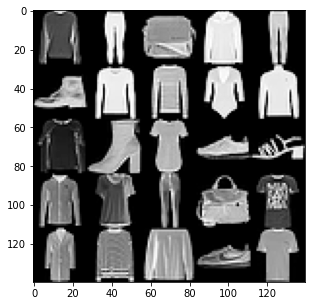

In [4]:
data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()


label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])


sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']


plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)

print(label_names[sample_labels.numpy().reshape(5, 5)])

In [5]:
print(data_train)

<CacheDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [6]:
def build_model(use_batchnorm=False, dropout_rate=0.):

  layers = []
  
  def add_layer(use_batchnorm, dropout_rate, n_filters, kernel_size):
    layers.append(tf.keras.layers.Conv2D(n_filters, kernel_size))
    if use_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Activation("elu"))
    if (dropout_rate > 0):
        layers.append(tf.keras.layers.Dropout(dropout_rate))
    layers.append(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  
  def dense(use_batchnorm, dropout_rate,dense_len):
      layers.append(tf.keras.layers.Dense(dense_len))
      if use_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())
      layers.append(tf.keras.layers.Activation("relu"))
      if (dropout_rate > 0):
        layers.append(tf.keras.layers.Dropout(dropout_rate))

  add_layer(use_batchnorm, dropout_rate,n_filters = 4, kernel_size = 3) #(13,13,4)
  add_layer(use_batchnorm, dropout_rate,n_filters = 10, kernel_size = 2) #(6,6,10)
  add_layer(use_batchnorm, dropout_rate,n_filters = 50, kernel_size = 3) #(2,2,50)
  add_layer(use_batchnorm, dropout_rate,n_filters = 100, kernel_size = 1) #(1,1,100)

  layers.append(tf.keras.layers.Reshape((100,), input_shape=(1,1,100)))
  
  dense(use_batchnorm, dropout_rate,64)
  dense(use_batchnorm, dropout_rate,32)
  dense(use_batchnorm, dropout_rate,16)

  layers.append(tf.keras.layers.Dense(10))
    
  model = tf.keras.Sequential(layers)
  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])
  return model

In [7]:
configs = [
  dict(use_batchnorm=False, dropout_rate=0),
  dict(use_batchnorm=False, dropout_rate=0.01),
  dict(use_batchnorm=False, dropout_rate=0.05),
  dict(use_batchnorm=False, dropout_rate=0.5),
  dict(use_batchnorm=True, dropout_rate=0),
  dict(use_batchnorm=True, dropout_rate=0.01),
  dict(use_batchnorm=True, dropout_rate=0.05),
  dict(use_batchnorm=True, dropout_rate=0.5),
]

models = {str(config) : build_model(**config) for config in configs}

In [8]:
batch_size = 512

def preprocess(x):
  return (tf.cast(x['image'], 'float32') / 255., x['label'])

for config, model in models.items():
  print("Working on model:", config)
  model.fit(x=data_train.map(preprocess).shuffle(60000).batch(batch_size), epochs=10,
            validation_data=data_test.map(preprocess).batch(4096))

Working on model: {'use_batchnorm': False, 'dropout_rate': 0}
Epoch 1/10
118/118 [==============================] - 7s 42ms/step - loss: 1.2958 - sparse_categorical_accuracy: 0.5278 - val_loss: 0.7815 - val_sparse_categorical_accuracy: 0.6893
Epoch 2/10
118/118 [==============================] - 5s 37ms/step - loss: 0.7017 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.6684 - val_sparse_categorical_accuracy: 0.7544
Epoch 3/10
118/118 [==============================] - 5s 38ms/step - loss: 0.6000 - sparse_categorical_accuracy: 0.7749 - val_loss: 0.5984 - val_sparse_categorical_accuracy: 0.7775
Epoch 4/10
118/118 [==============================] - 6s 46ms/step - loss: 0.5436 - sparse_categorical_accuracy: 0.7987 - val_loss: 0.5515 - val_sparse_categorical_accuracy: 0.8004
Epoch 5/10
118/118 [==============================] - 6s 46ms/step - loss: 0.5121 - sparse_categorical_accuracy: 0.8116 - val_loss: 0.5170 - val_sparse_categorical_accuracy: 0.8154
Epoch 6/10
118/118 [=============

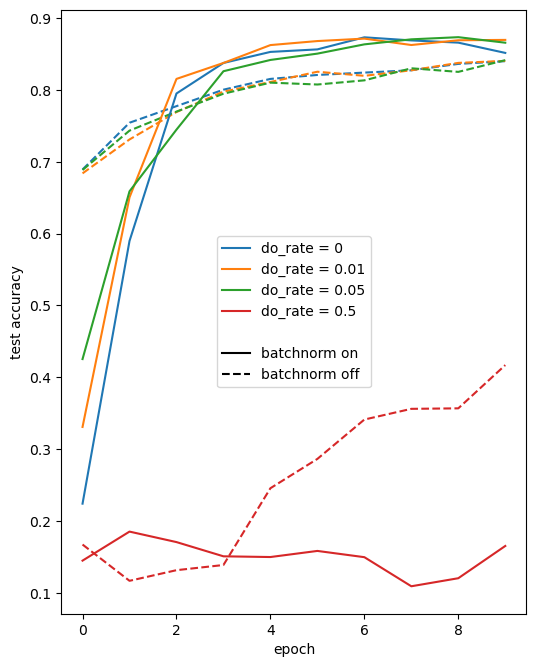

In [9]:
plt.figure(figsize=(6, 8), dpi=100)
color_cycle = iter(plt.rcParams['axes.prop_cycle'])

colors = {}

lines = []
labels = []
for config, model in models.items():
  config = eval(config)
  if config['dropout_rate'] not in colors:
    colors[config['dropout_rate']] = next(color_cycle)

  color = colors[config['dropout_rate']]['color']

  style = '-' if config['use_batchnorm'] else '--'
  line, = plt.plot(model.history.history['val_sparse_categorical_accuracy'], style,
                   c=color)
  
  if config['use_batchnorm']:
    lines.append(line)
    labels.append(f"do_rate = {config['dropout_rate']}")

plt.xlabel("epoch")
plt.ylabel("test accuracy");

from matplotlib.lines import Line2D

lines += [Line2D([0], [0], linestyle='-', color='w'),
          Line2D([0], [0], linestyle='-', color='k'),
          Line2D([0], [0], linestyle='--', color='k')]
labels += ['', 'batchnorm on', 'batchnorm off']
plt.legend(lines, labels);